# 3_Preprocessing2

 1. 지역변수 (bus_route_id로)  
 2. test 데이터셋도 저번과 동일한 처리해주기
 3. 결측치 처리  
 4. One-hot encoding  
 5. Scaling

references :   
https://velog.io/@songjeongwoo/series/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC  
결측치 조치 -> 가변수화 -> kNN Imputer -> 스케일링  
train, test 반드시 동일한 전처리 과정을 거쳐야 한다.

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import matplotlib.pylab as plt
import warnings

In [2]:
train = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/pre1_train", encoding='utf-8')
train.set_index('id', inplace=True)
train

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,region_class,weather,dayofwk,holiday,bus_route_class
id,,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,4,1,3,0,1
1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,5.0,4,1,3,0,1
2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,4,1,3,0,1
3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,...,0.0,0.0,0.0,0.0,53.0,4,1,3,0,1
4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,4,0,1
415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,1,4,0,1
415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,4,0,1


**범주형 변수**  
1. region_class
- 1: 서부 (longitude <= 126.35, latitude < 33.5)
- 2: 남부 (126.35 < longitude < 126.725, latitude < 33.32)
- 3: 동부 (longitude >= 126.75)
- 4: 북부 (126.35 < longitude < 126.725, latitude > 33.42)
- 5: 기타 (추자도, 산지)
  
2. weather
- 1: 비 안오거나 약한 비 (일 강수량 40mm 이하)
- 2: 보통 비 (일 강수량 40mm 초과 130mm 이하)
- 3: 폭우 (일 강수량 130mm 초과)  
  
3. dayofwk
- 1: 월 ~ 7: 일  
  
4. holiday  
- 0: 공휴일 X
- 1: 공휴일 O (주말, 추석연휴)  
  
5. bus_route_class  
- 1: 버스 노선의 10~11 ride 수가 1078 이하  
- 2: 버스 노선의 10~11 ride 수가 1078 초과  
  
6. in_out
- 0: 시내(in)  
- 1: 시외(out)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             415423 non-null  object 
 1   bus_route_id     415423 non-null  int64  
 2   in_out           415423 non-null  int64  
 3   station_code     415423 non-null  int64  
 4   station_name     415423 non-null  object 
 5   latitude         415423 non-null  float64
 6   longitude        415423 non-null  float64
 7   6~7_ride         415423 non-null  float64
 8   7~8_ride         415423 non-null  float64
 9   8~9_ride         415423 non-null  float64
 10  9~10_ride        415423 non-null  float64
 11  10~11_ride       415423 non-null  float64
 12  11~12_ride       415423 non-null  float64
 13  6~7_takeoff      415423 non-null  float64
 14  7~8_takeoff      415423 non-null  float64
 15  8~9_takeoff      415423 non-null  float64
 16  9~10_takeoff     415423 non-null  floa

## bus_route_id로 지역변수

In [4]:
train["bus_route_id"].unique()

array([ 4270000,  4280000,  8170000,  8180000, 17010000, 20010000,
       20040000, 20050000, 21000000, 21010000, 21020000, 21040000,
       21070000, 21080000, 21090000, 21100000, 21110000, 21120000,
       21150000, 21180000, 21200000, 21220000, 21230000, 21270000,
       21290000, 21300000, 21310000, 21330000, 21340000, 21350000,
       21360000, 21370000, 21390000, 21400000, 21410000, 21420000,
       21430000, 21440000, 21450000, 21460000, 21470000, 21480000,
       21500000, 21520000, 21540000, 21550000, 21580000, 21600000,
       21610000, 21620000, 21720000, 21780000, 21810000, 21820000,
       21830000, 21880000, 21910000, 21920000, 21930000, 21940000,
       21970000, 21980000, 22180000, 22190000, 22200000, 22210000,
       22220000, 22230000, 22240000, 22250000, 22340000, 22350000,
       22360000, 22370000, 22440000, 22450000, 22460000, 22470000,
       22480000, 22490000, 22500000, 22510000, 22520000, 22530000,
       22540000, 22550000, 22560000, 22570000, 22580000, 22600

In [5]:
# 버스 루트 아이디가 몇개는 in이고 몇개는 out일 수가 있나? 같은 노선이면 시외면 시외, 시내면 시내 아닌가? 
train[train["bus_route_id"]==4270000][["in_out", "station_name", "region_class"]]

,in_out,station_name,region_class
id,,,
0,1,제주썬호텔,4
1,1,한라병원,4
2,1,정존마을,4
3,0,제주국제공항(600번),4
4,0,중문관광단지입구,2
...,...,...,...
399564,0,제주월드컵경기장(600번),2
399565,1,월평마을,2
399566,0,롯데시티호텔(600번),4


In [6]:
# bus_route_id가 내가 알고 있는 버스 노선의 개념이 아닌 듯 하다 아래 버스루트는 제주 동쪽과 우도 다니는 버스루트
train[train["bus_route_id"]==31070000][["in_out", "station_name", "region_class"]]

,in_out,station_name,region_class
id,,,
23705,0,상덕천마을입구,5
23706,0,덕천리,3
23707,0,김녕환승정류장(김녕초등학교),3
23708,0,구좌정수장,3
54061,0,덕천리,3
...,...,...,...
397374,0,구좌정수장,3
412510,0,상덕천마을입구,5
412511,0,덕천리,3


## 결측치

In [7]:
# 결측치 없음 -> 처리해줄 필요 없음
# weather은 이미 train셋에 맵핑 시켜줄 때 시계열로 보간해줌 (interpolate)
train.isna().sum()

date               0
bus_route_id       0
in_out             0
station_code       0
station_name       0
latitude           0
longitude          0
6~7_ride           0
7~8_ride           0
8~9_ride           0
9~10_ride          0
10~11_ride         0
11~12_ride         0
6~7_takeoff        0
7~8_takeoff        0
8~9_takeoff        0
9~10_takeoff       0
10~11_takeoff      0
11~12_takeoff      0
18~20_ride         0
region_class       0
weather            0
dayofwk            0
holiday            0
bus_route_class    0
dtype: int64

## test 저번에 train이 한 과정 거치기

In [8]:
test = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/test.csv")
test.set_index("id", inplace=True)
test

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
id,,,,,,,,,,,,,,,,,,,
415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643588,2019-10-16,32820000,시내,786,고산환승정류장(고산1리),33.30073,126.18044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
643589,2019-10-16,32820000,시내,1080,애월고등학교,33.46262,126.33447,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
643590,2019-10-16,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 지역 변수
region_class= []

for i in range (len(test)):
    if ((test["longitude"].iloc[i].item() <= 126.35) & (test["latitude"].iloc[i].item() < 33.5)):
        region_class.append(1)
    elif ((test["longitude"].iloc[i].item() > 126.35) & (test["longitude"].iloc[i].item() < 126.725) & (test["latitude"].iloc[i].item() < 33.32)):
        region_class.append(2)
    elif ((test["longitude"].iloc[i].item() >= 126.75)):
        region_class.append(3)
    elif ((test["longitude"].iloc[i].item() > 126.35) & (test["longitude"].iloc[i].item() < 126.725) & (test["latitude"].iloc[i].item() > 33.42)):
        region_class.append(4)
    else:
        region_class.append(5)

In [10]:
test["region_class"] = region_class

In [11]:
# weather
# 문제 : test에 맵핑 시킬 강수량 데이터셋이 없음 -> 기상청 기상자료포털에서 얻음 (https://data.kma.go.kr/cmmn/main.do)
test_weather = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/OBS_ASOS_TIM_201910.csv", encoding="euc-kr")
test_weather

,지점,지점명,일시,강수량(mm)
0,184,제주,2019-10-01 07:00,0.7
1,184,제주,2019-10-01 11:00,0.0
2,184,제주,2019-10-01 12:00,0.0
3,184,제주,2019-10-01 13:00,0.3
4,184,제주,2019-10-01 14:00,5.7
...,...,...,...,...
202,189,서귀포,2019-10-06 11:00,0.2
203,189,서귀포,2019-10-07 11:00,0.0
204,189,서귀포,2019-10-07 12:00,2.3
205,189,서귀포,2019-10-07 13:00,6.8


In [12]:
test_weather["지점명"].unique()

array(['제주', '고산', '성산', '서귀포'], dtype=object)

In [13]:
test_weather["지점"].unique()

array([184, 185, 188, 189], dtype=int64)

In [14]:
test_weather["일시"] = pd.to_datetime(test_weather.일시, format="%Y-%m-%d %H:%M")

In [15]:
weather_jeju = test_weather[test_weather["지점"]==184]
weather_gosan = test_weather[test_weather["지점"]==185]
weather_seongsan = test_weather[test_weather["지점"]==188]
weather_seoguipo = test_weather[test_weather["지점"]==189]

In [16]:
weather_jeju["날짜"]= weather_jeju["일시"].dt.date
weather_gosan["날짜"]=weather_gosan["일시"].dt.date
weather_seongsan["날짜"]= weather_seongsan["일시"].dt.date
weather_seoguipo["날짜"]=weather_seoguipo["일시"].dt.date

C:\Users\kimch\AppData\Local\Temp/ipykernel_10520/2138000546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_jeju["날짜"]= weather_jeju["일시"].dt.date
C:\Users\kimch\AppData\Local\Temp/ipykernel_10520/2138000546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_gosan["날짜"]=weather_gosan["일시"].dt.date
C:\Users\kimch\AppData\Local\Temp/ipykernel_10520/2138000546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [17]:
weather_jeju = weather_jeju[["강수량(mm)", "날짜"]]
weather_gosan = weather_gosan[["강수량(mm)", "날짜"]]
weather_seongsan = weather_seongsan[["강수량(mm)", "날짜"]]
weather_seoguipo = weather_seoguipo[["강수량(mm)", "날짜"]]

In [18]:
# 누적 강수량 구하기
rain_jeju = weather_jeju.groupby('날짜').sum()
rain_gosan = weather_gosan.groupby('날짜').sum()
rain_seongsan = weather_seongsan.groupby('날짜').sum()
rain_seoguipo = weather_seoguipo.groupby('날짜').sum()

In [19]:
# 결측치 확인 -> 많음,, 절반 이상이 결측치,,,,
print(len(rain_jeju))
print(len(rain_gosan))
print(len(rain_seongsan))
print(len(rain_seoguipo))

6
5
5
6


In [20]:
rain_jeju = pd.DataFrame({"date": pd.date_range("2019-10-01", "2019-10-16", freq="D"),
                          "rain": [25.4, 140.70000000000002, 1.5, np.nan, np.nan, 1.0, 0.0, np.nan, np.nan, np.nan, np.nan, np.nan,
                                   np.nan, np.nan, 3.2, np.nan]})

In [21]:
rain_gosan = pd.DataFrame({"date": pd.date_range("2019-10-01", "2019-10-16", freq="D"),
                           "rain": [16.4, 103.60000000000001, 0.7000000000000001, np.nan, np.nan, np.nan, 2.2, 0.0, np.nan, np.nan,
                                   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]})

In [22]:
rain_seongsan = pd.DataFrame({"date": pd.date_range("2019-10-01", "2019-10-16", freq="D"),
                             "rain": [23.4, 147.9, np.nan, np.nan, np.nan, 0.1, 1.2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                                      np.nan, 4.3, np.nan]})

In [23]:
rain_seoguipo = pd.DataFrame({"date": pd.date_range("2019-10-01", "2019-10-16", freq="D"),
                          "rain": [30.0, 108.1, 0.1, np.nan, np.nan, 0.2, 9.1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                                   0.0, np.nan]})

In [24]:
rain_gosan.reset_index(inplace=True)
rain_seoguipo.reset_index(inplace=True)
rain_seongsan.reset_index(inplace=True)
rain_jeju.reset_index(inplace=True)

In [25]:
rain_gosan["date"] = pd.to_datetime(rain_gosan.date, format="%Y-%m-%d")
rain_seoguipo["date"] = pd.to_datetime(rain_seoguipo.date, format="%Y-%m-%d")
rain_seongsan["date"] = pd.to_datetime(rain_seongsan.date, format="%Y-%m-%d")
rain_jeju["date"] = pd.to_datetime(rain_jeju.date, format="%Y-%m-%d")

In [26]:
rain_gosan = rain_gosan.set_index("date")
rain_seoguipo = rain_seoguipo.set_index("date")
rain_seongsan = rain_seongsan.set_index("date")
rain_jeju = rain_jeju.set_index("date")

In [27]:
# 시계열 데이터 -> 결측치 시계열로 보간하는 interpolate 사용 
rain_gosan_fillna = rain_jeju.interpolate(method="time")
rain_seoguipo_fillna = rain_seoguipo.interpolate(method="time")
rain_seongsan_fillna = rain_seongsan.interpolate(method="time")
rain_jeju_fillna = rain_jeju.interpolate(method="time")

In [28]:
# 결측치 보간 완료
print(rain_gosan_fillna.isna().sum())
print(rain_seoguipo_fillna.isna().sum())
print(rain_seongsan_fillna.isna().sum())
print(rain_jeju_fillna.isna().sum())

index    0
rain     0
dtype: int64
index    0
rain     0
dtype: int64
index    0
rain     0
dtype: int64
index    0
rain     0
dtype: int64


In [29]:
rain_jeju = rain_jeju_fillna[["rain"]]
rain_gosan = rain_gosan_fillna[["rain"]]
rain_seoguipo = rain_seoguipo_fillna[["rain"]]
rain_seongsan = rain_seongsan_fillna[["rain"]]

In [30]:
rain_class = []

for j in range (16):
    if (rain_jeju.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_jeju.iloc[j].item() > 40) & (rain_jeju.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_jeju.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_jeju["rain_class"] = rain_class

In [31]:
rain_class = []

for j in range (16):
    if (rain_gosan.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_gosan.iloc[j].item() > 40) & (rain_gosan.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_gosan.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_gosan["rain_class"] = rain_class

In [32]:
rain_class = []

for j in range (16):
    if (rain_seongsan.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_seongsan.iloc[j].item() > 40) & (rain_seongsan.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_seongsan.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_seongsan["rain_class"] = rain_class

In [33]:
rain_class = []

for j in range (16):
    if (rain_seoguipo.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_seoguipo.iloc[j].item() > 40) & (rain_seoguipo.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_seoguipo.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_seoguipo["rain_class"] = rain_class

In [34]:
rain_total = pd.DataFrame({"date":list(rain_seoguipo.index.values), 
                           "1:gosan": list(rain_gosan["rain_class"].values),
                           "2:seoguipo": list(rain_seoguipo["rain_class"].values), 
                           "3:seongsan": list(rain_seongsan["rain_class"].values),
                           "4:jeju": list(rain_jeju["rain_class"].values)})
rain_total

,date,1:gosan,2:seoguipo,3:seongsan,4:jeju
0,2019-10-01,1,1,1,1
1,2019-10-02,3,2,3,3
2,2019-10-03,1,1,2,1
3,2019-10-04,1,1,2,1
4,2019-10-05,1,1,1,1
5,2019-10-06,1,1,1,1
6,2019-10-07,1,1,1,1
7,2019-10-08,1,1,1,1
8,2019-10-09,1,1,1,1
9,2019-10-10,1,1,1,1


In [35]:
# test셋도 지역마다 강수량이 크게 차이 안남, train에서 한 처리와 동일하게 평균내고 반올림
rain_total["5:other"] = [int(round(sum(rain_total.iloc[i][1:])/4,1)) for i in range(16)]
rain_total

,date,1:gosan,2:seoguipo,3:seongsan,4:jeju,5:other
0,2019-10-01,1,1,1,1,1
1,2019-10-02,3,2,3,3,2
2,2019-10-03,1,1,2,1,1
3,2019-10-04,1,1,2,1,1
4,2019-10-05,1,1,1,1,1
5,2019-10-06,1,1,1,1,1
6,2019-10-07,1,1,1,1,1
7,2019-10-08,1,1,1,1,1
8,2019-10-09,1,1,1,1,1
9,2019-10-10,1,1,1,1,1


In [36]:
rain_total["day"] = rain_total["date"].dt.day

In [37]:
test["date"] = pd.to_datetime(test.date, format="%Y-%m-%d")
test["day"] = test["date"].dt.day

In [38]:
# test에 날씨 변수 맵핑
weather = []
for i in range (len(test)):
    for j in range (16):
        if test["day"].iloc[i] == rain_total["day"].iloc[j]:
            weather.append(rain_total.iloc[j,test["region_class"].iloc[i]])

In [39]:
test["weather"]= weather

In [40]:
# dayofwk 
dayofwk= []

for i in range (len(test)):
    if (test["day"].iloc[i] % 7 == 0):
        dayofwk.append(1)
    elif (test["day"].iloc[i] % 7 == 1):
        dayofwk.append(2)
    elif (test["day"].iloc[i] % 7 == 2):
        dayofwk.append(3)
    elif (test["day"].iloc[i] % 7 == 3):
        dayofwk.append(4)
    elif (test["day"].iloc[i] % 7 == 4):
        dayofwk.append(5)
    elif (test["day"].iloc[i] % 7 == 5):
        dayofwk.append(6)
    elif (test["day"].iloc[i] % 7 == 6):
        dayofwk.append(7)
        
test["dayofwk"] = dayofwk

In [41]:
# holiday
holiday = []

for i in range (len(test)):
    if (test["day"].iloc[i] % 7 == 5 or test["day"].iloc[i] % 7 == 6 or test["day"].iloc[i] == 3 or test["day"].iloc[i] == 9):
        holiday.append(1)
    else:
        holiday.append(0)
        
test["holiday"] = holiday

In [42]:
test = test.drop(columns=["day"])

In [43]:
# bus_route_id
bus_route = pd.pivot_table(test, index = "bus_route_id", values=['6~7_ride', '7~8_ride', '8~9_ride','9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff'], aggfunc="sum")

In [44]:
test.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       'region_class', 'weather', 'dayofwk', 'holiday'],
      dtype='object')

In [45]:
# 문제 : train에서만 18~20_ride가 있음 -> train이랑 기준 같아야하는데 다시 세워야할 듯,,,,,
test_date_ride = pd.DataFrame({"date": pd.date_range("2019-10-01", "2019-10-16", freq="D")})

for i in range (7, 18):
    test_date_ride[test.columns[i]] = test.groupby("date")[test.columns[i]].sum().values

test_date_ride

,date,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff
0,2019-10-01,4366.0,14690.0,14749.0,11070.0,9673.0,8862.0,1426.0,5494.0,9007.0,7328.0,6739.0
1,2019-10-02,2923.0,10011.0,10504.0,7682.0,7099.0,7168.0,910.0,3663.0,6435.0,5042.0,4706.0
2,2019-10-03,2496.0,4301.0,5724.0,6823.0,7119.0,7944.0,1040.0,2492.0,3541.0,4193.0,4696.0
3,2019-10-04,4807.0,11313.0,13280.0,11504.0,10546.0,10553.0,1898.0,5292.0,8697.0,7839.0,7343.0
4,2019-10-05,3548.0,6380.0,8485.0,9370.0,9449.0,9565.0,1602.0,3498.0,5278.0,6023.0,6325.0
5,2019-10-06,2653.0,4289.0,6281.0,7126.0,7462.0,7769.0,1214.0,2477.0,3753.0,4477.0,5144.0
6,2019-10-07,5392.0,16397.0,15573.0,11301.0,10364.0,9891.0,1857.0,6342.0,10067.0,7568.0,7169.0
7,2019-10-08,5392.0,16404.0,15386.0,11102.0,9996.0,9405.0,1781.0,6439.0,9823.0,7642.0,7023.0
8,2019-10-09,3368.0,5650.0,7297.0,8110.0,8468.0,8773.0,1524.0,3375.0,4608.0,5300.0,5820.0
9,2019-10-10,5517.0,16694.0,15821.0,11345.0,10334.0,9732.0,1935.0,6468.0,10003.0,8040.0,7156.0


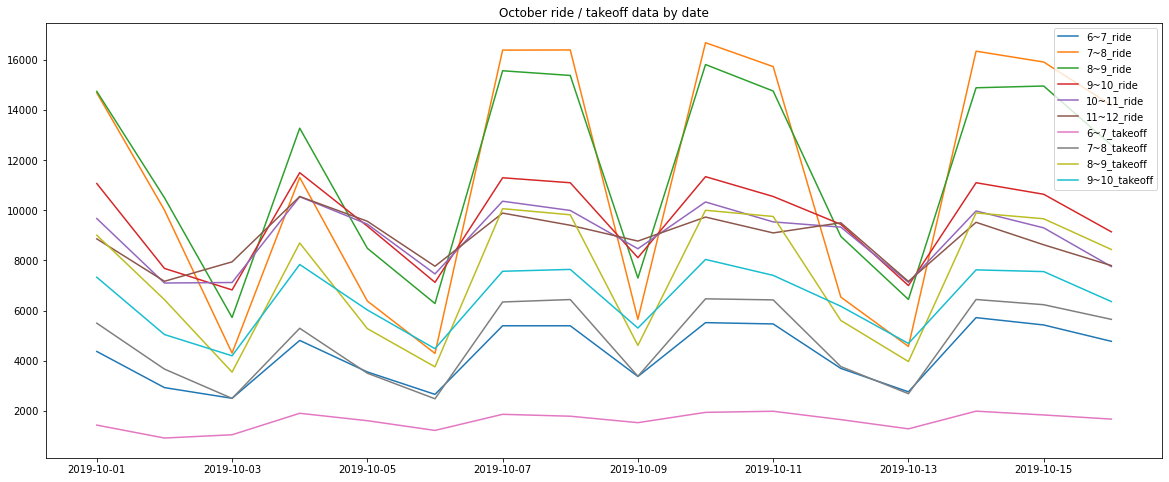

In [46]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()

for i in range (1, 11):
    ax.plot(test_date_ride.date, test_date_ride.iloc[:,i], label = test_date_ride.columns[i])
    
ax.legend()
plt.title('October ride / takeoff data by date')
plt.show()

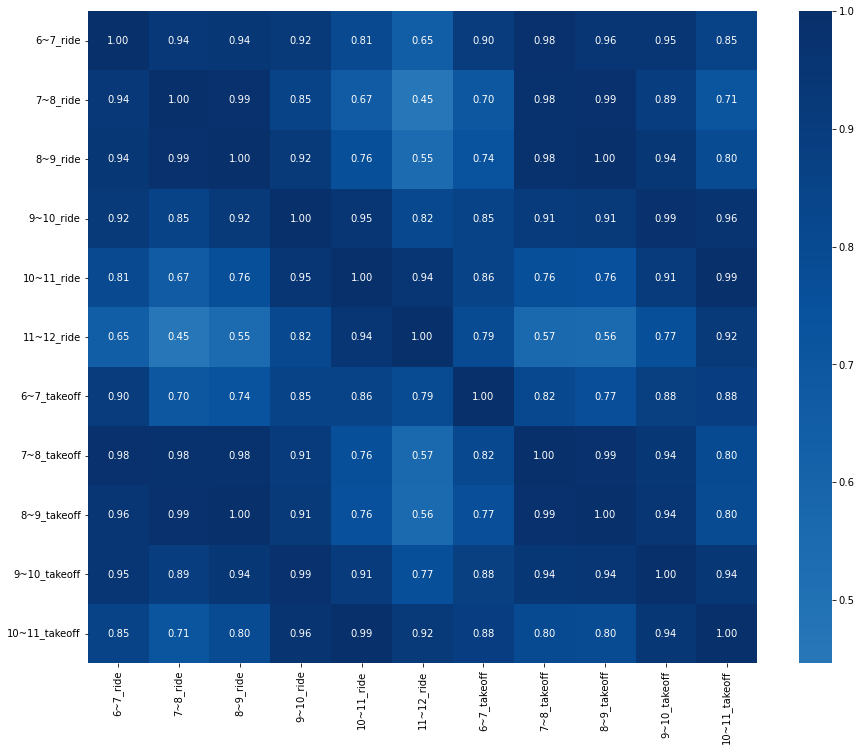

In [47]:
# 상관관계
corr = test_date_ride.corr()

fig, ax = plt.subplots()
fig.set_size_inches(15,12)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", center=0, ax=ax)

plt.show()

In [48]:
bus_route.describe()

,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,238.838602,164.998336,235.224626,165.417637,113.617304,42.542429,298.577371,127.670549,309.031614,197.229617,255.099834,171.797005
std,504.972190,336.105165,514.036647,346.022105,196.413959,84.309323,483.544198,212.776388,564.981741,338.029299,527.970798,337.231827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,1.000000,1.000000,0.000000,0.000000
50%,44.000000,30.000000,38.000000,27.000000,28.000000,5.000000,99.000000,45.000000,70.000000,56.000000,40.000000,31.000000
75%,259.000000,190.000000,226.000000,175.000000,152.000000,51.000000,373.000000,160.000000,378.000000,251.000000,277.000000,192.000000
max,4637.000000,2850.000000,4893.000000,2972.000000,1956.000000,737.000000,3697.000000,1819.000000,4192.000000,2510.000000,4404.000000,2781.000000


In [49]:
# train 데이터셋 EDA 했을 때 18~20_ride는 9~10_ride, 10~11_ride / 8~9_ride와 분포가 비슷해보이고, 상관관계도 높음 
# 10~11_ride가 상관관계도 높고 수도 비슷해보임 -> 10~11_ride 기준으로 
busroute_class = []
for i in range (len(bus_route)):
    if (bus_route["10~11_ride"].iloc[i]<=1078):
        busroute_class.append(1)
    elif ((bus_route["10~11_ride"].iloc[i] > 1078)):
        busroute_class.append(2)
bus_route["busroute_class"] = busroute_class

In [50]:
bus_route_class = []

for i in range (len(test)):
    if (test["bus_route_id"].iloc[i] in list(bus_route[bus_route["busroute_class"]==1].index)):
        bus_route_class.append(1)
    elif (test["bus_route_id"].iloc[i] in list(bus_route[bus_route["busroute_class"]==2].index)):
        bus_route_class.append(2)
        
test["bus_route_class"] = bus_route_class

In [51]:
# 시내 / 시외 -> 0 / 1 로 변경
test = test.replace("시내", 0)
test = test.replace("시외", 1)

In [52]:
# 18~20_ride 없어서 범주형 변수 5개 추가돼서 test는 총 24 columns
test

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,region_class,weather,dayofwk,holiday,bus_route_class
id,,,,,,,,,,,,,,,,,,,,,
415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,...,0.0,0.0,0.0,0.0,1.0,4,1,2,0,1
415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,4,1,2,0,1
415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,4,1,2,0,1
415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,...,0.0,0.0,0.0,0.0,0.0,4,1,2,0,1
415427,2019-10-01,4270000,0,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643588,2019-10-16,32820000,0,786,고산환승정류장(고산1리),33.30073,126.18044,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1,1,3,0,1
643589,2019-10-16,32820000,0,1080,애월고등학교,33.46262,126.33447,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,3,0,1
643590,2019-10-16,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,3,0,1


In [53]:
# 지금까지 전처리된 test셋도 저장
test.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/pre1_test")

## 범주형 변수 : One-hot Encoding or Label Encoding

references : https://velog.io/@songjeongwoo/%EA%B0%80%EB%B3%80%EC%88%98%ED%99%94   
범주형 변수들 중에서 숫자에 따라 정도를 나타내는 weather, bus_route_class를 제외한 변수들을 가변수화 해줌

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             415423 non-null  object 
 1   bus_route_id     415423 non-null  int64  
 2   in_out           415423 non-null  int64  
 3   station_code     415423 non-null  int64  
 4   station_name     415423 non-null  object 
 5   latitude         415423 non-null  float64
 6   longitude        415423 non-null  float64
 7   6~7_ride         415423 non-null  float64
 8   7~8_ride         415423 non-null  float64
 9   8~9_ride         415423 non-null  float64
 10  9~10_ride        415423 non-null  float64
 11  10~11_ride       415423 non-null  float64
 12  11~12_ride       415423 non-null  float64
 13  6~7_takeoff      415423 non-null  float64
 14  7~8_takeoff      415423 non-null  float64
 15  8~9_takeoff      415423 non-null  float64
 16  9~10_takeoff     415423 non-null  floa

In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 415423 to 643592
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             228170 non-null  datetime64[ns]
 1   bus_route_id     228170 non-null  int64         
 2   in_out           228170 non-null  int64         
 3   station_code     228170 non-null  int64         
 4   station_name     228170 non-null  object        
 5   latitude         228170 non-null  float64       
 6   longitude        228170 non-null  float64       
 7   6~7_ride         228170 non-null  float64       
 8   7~8_ride         228170 non-null  float64       
 9   8~9_ride         228170 non-null  float64       
 10  9~10_ride        228170 non-null  float64       
 11  10~11_ride       228170 non-null  float64       
 12  11~12_ride       228170 non-null  float64       
 13  6~7_takeoff      228170 non-null  float64       
 14  7~8_takeoff    

In [56]:
# 원핫인코딩 하기 전에 해석하면서 의미 잘 알아듣게
# region_class : 1~ 5 => west ~ other로 / dayofwk : 1~ 7 => mon ~ sun로 / in_out : in, out으로

## region_class
train.loc[train["region_class"]==1, "region_class"] = "west"
train.loc[train["region_class"]==2, "region_class"] = "south"
train.loc[train["region_class"]==3, "region_class"] = "east"
train.loc[train["region_class"]==4, "region_class"] = "north"
train.loc[train["region_class"]==5, "region_class"] = "other"

## dayofwk
train.loc[train["dayofwk"]==1, "dayofwk"] = "mon"
train.loc[train["dayofwk"]==2, "dayofwk"] = "tue"
train.loc[train["dayofwk"]==3, "dayofwk"] = "wed"
train.loc[train["dayofwk"]==4, "dayofwk"] = "thur"
train.loc[train["dayofwk"]==5, "dayofwk"] = "fri"
train.loc[train["dayofwk"]==6, "dayofwk"] = "sat"
train.loc[train["dayofwk"]==7, "dayofwk"] = "sun" 

## in_out
train.loc[train["in_out"]==0, "in_out"] = "in"
train.loc[train["in_out"]==1, "in_out"] = "out"

In [57]:
# test도 위와 동일 과정 

## region_class
test.loc[test["region_class"]==1, "region_class"] = "west"
test.loc[test["region_class"]==2, "region_class"] = "south"
test.loc[test["region_class"]==3, "region_class"] = "east"
test.loc[test["region_class"]==4, "region_class"] = "north"
test.loc[test["region_class"]==5, "region_class"] = "other"

## dayofwk
test.loc[test["dayofwk"]==1, "dayofwk"] = "mon"
test.loc[test["dayofwk"]==2, "dayofwk"] = "tue"
test.loc[test["dayofwk"]==3, "dayofwk"] = "wed"
test.loc[test["dayofwk"]==4, "dayofwk"] = "thur"
test.loc[test["dayofwk"]==5, "dayofwk"] = "fri"
test.loc[test["dayofwk"]==6, "dayofwk"] = "sat"
test.loc[test["dayofwk"]==7, "dayofwk"] = "sun" 

## in_out
test.loc[test["in_out"]==0, "in_out"] = "in"
test.loc[test["in_out"]==1, "in_out"] = "out"

In [58]:
# 컬럼명도 원핫인코딩 후 깔끔하게 나오도록 바꿔줌
train = train.rename(columns={"region_class":"region", "in_out":"inout"})
test = test.rename(columns={"region_class":"region", "in_out":"inout"})

In [59]:
# DateTime Index랑 범주형 변수는 데이터셋에 저장이 안되는건가 다시 설정해줌
train["date"] = pd.to_datetime(train.date, format='%Y-%m-%d')
test["date"] = pd.to_datetime(test.date, format="%Y-%m-%d")

categorical = ["region", "weather", "dayofwk", "holiday", "bus_route_class", "inout"]
train[categorical] = train[categorical].astype('category')
test[categorical] = test[categorical].astype('category')

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             415423 non-null  datetime64[ns]
 1   bus_route_id     415423 non-null  int64         
 2   inout            415423 non-null  category      
 3   station_code     415423 non-null  int64         
 4   station_name     415423 non-null  object        
 5   latitude         415423 non-null  float64       
 6   longitude        415423 non-null  float64       
 7   6~7_ride         415423 non-null  float64       
 8   7~8_ride         415423 non-null  float64       
 9   8~9_ride         415423 non-null  float64       
 10  9~10_ride        415423 non-null  float64       
 11  10~11_ride       415423 non-null  float64       
 12  11~12_ride       415423 non-null  float64       
 13  6~7_takeoff      415423 non-null  float64       
 14  7~8_takeoff      415

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 415423 to 643592
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             228170 non-null  datetime64[ns]
 1   bus_route_id     228170 non-null  int64         
 2   inout            228170 non-null  category      
 3   station_code     228170 non-null  int64         
 4   station_name     228170 non-null  object        
 5   latitude         228170 non-null  float64       
 6   longitude        228170 non-null  float64       
 7   6~7_ride         228170 non-null  float64       
 8   7~8_ride         228170 non-null  float64       
 9   8~9_ride         228170 non-null  float64       
 10  9~10_ride        228170 non-null  float64       
 11  10~11_ride       228170 non-null  float64       
 12  11~12_ride       228170 non-null  float64       
 13  6~7_takeoff      228170 non-null  float64       
 14  7~8_takeoff    

In [62]:
# 지금까지 전처리 완료된 데이터셋 저장 
train.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/pre2_train")
test.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/pre2_test")

<AxesSubplot:xlabel='18~20_ride', ylabel='region'>

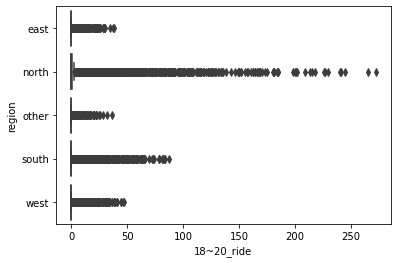

In [63]:
#범주형 변수 그룹별 승하차수가 어떻게 되는지 궁금해서 박스플롯 그려봄
# region_class
sns.boxplot(y="region", x="18~20_ride", data=train)

<AxesSubplot:xlabel='18~20_ride', ylabel='weather'>

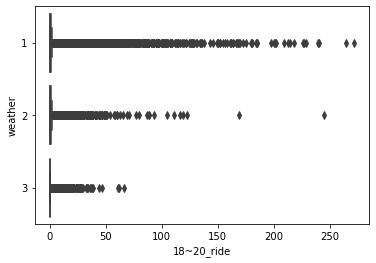

In [64]:
# weather
sns.boxplot(y="weather", x="18~20_ride", data=train)

<AxesSubplot:xlabel='18~20_ride', ylabel='dayofwk'>

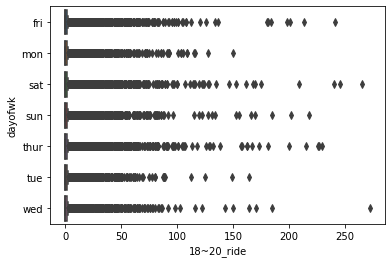

In [65]:
# dayofwk
sns.boxplot(y="dayofwk", x="18~20_ride", data=train)

<AxesSubplot:xlabel='18~20_ride', ylabel='holiday'>

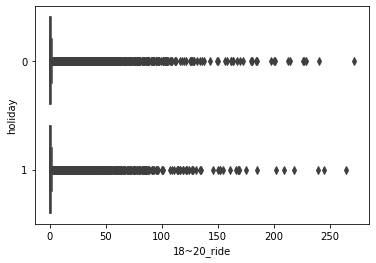

In [66]:
# holiday
sns.boxplot(y="holiday", x="18~20_ride", data=train)

<AxesSubplot:xlabel='18~20_ride', ylabel='bus_route_class'>

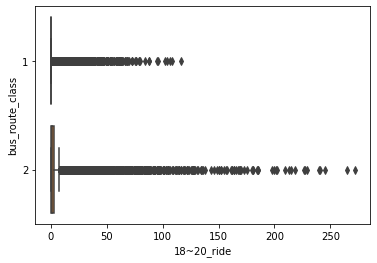

In [67]:
# bus_route_class
sns.boxplot(y="bus_route_class", x="18~20_ride", data=train)

<AxesSubplot:xlabel='18~20_ride', ylabel='inout'>

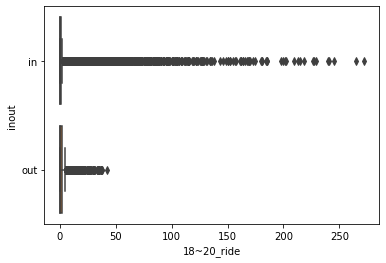

In [68]:
# inout
sns.boxplot(y="inout", x="18~20_ride", data=train)

### 라벨인코딩 vs 원핫인코딩
  
**라벨인코딩** :   
숫자값을 가중치로 잘못 인식하여 값에 왜곡이 생길 수 있음 -> 예측 저하  
회귀모델에는 no, 트리계열 ok  
**원핫인코딩** :  
다중공선성 생김 -> 변수선택 or 주성분 분석에서 해결 가능 
  
references : https://hye-z.tistory.com/m/16    

In [68]:
# 순서형 범주형 변수 제외 One-hot Encoding
# train = pd.get_dummies(train, columns=["region", "dayofwk", "holiday", "inout"], prefix_sep="_", drop_first=True)
# test = pd.get_dummies(test, columns=["region", "dayofwk", "holiday", "inout"], prefix_sep="_", drop_first=True)

## 수치형 변수 : Scaling  
references : https://velog.io/@songjeongwoo/%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81-77xf6ne8

수치형 변수: latitude, longtitude -> region 범주형 변수 만듬 그 외 승객수여서 스케일링 하는게 맞나..?  
스케일링 : 아래 둘 중 하나만 진행
- 1. 표준화 : 분포의 범위가 다양할 때 분포를 비교하기 위해 정규분포(평균 0, 표준편차 1)로, 이상치와 상관없이 분포 유지됨
- 2. 정규화 : 모든 변수를 [0,1] 사이 값으로 변환, 이상치가 크면 분포가 더 압축됨
  
스케일링이 필요한 알고리즘 : 거리 계산하는 알고리즘 (KNN, SVM 등) -> *분류 알고리즘 아님?* + 회귀모델도 꼭 해야한다 함

In [71]:
# 수치형 변수 분포
numerical = [['latitude', 'longitude', '6~7_ride'], ['7~8_ride', '8~9_ride', '9~10_ride'], ['10~11_ride', '11~12_ride', '6~7_takeoff'], 
             ['7~8_takeoff', '8~9_takeoff', '9~10_takeoff'], ['10~11_takeoff', '11~12_takeoff', '18~20_ride']]

In [72]:
import warnings
warnings.filterwarnings('ignore')

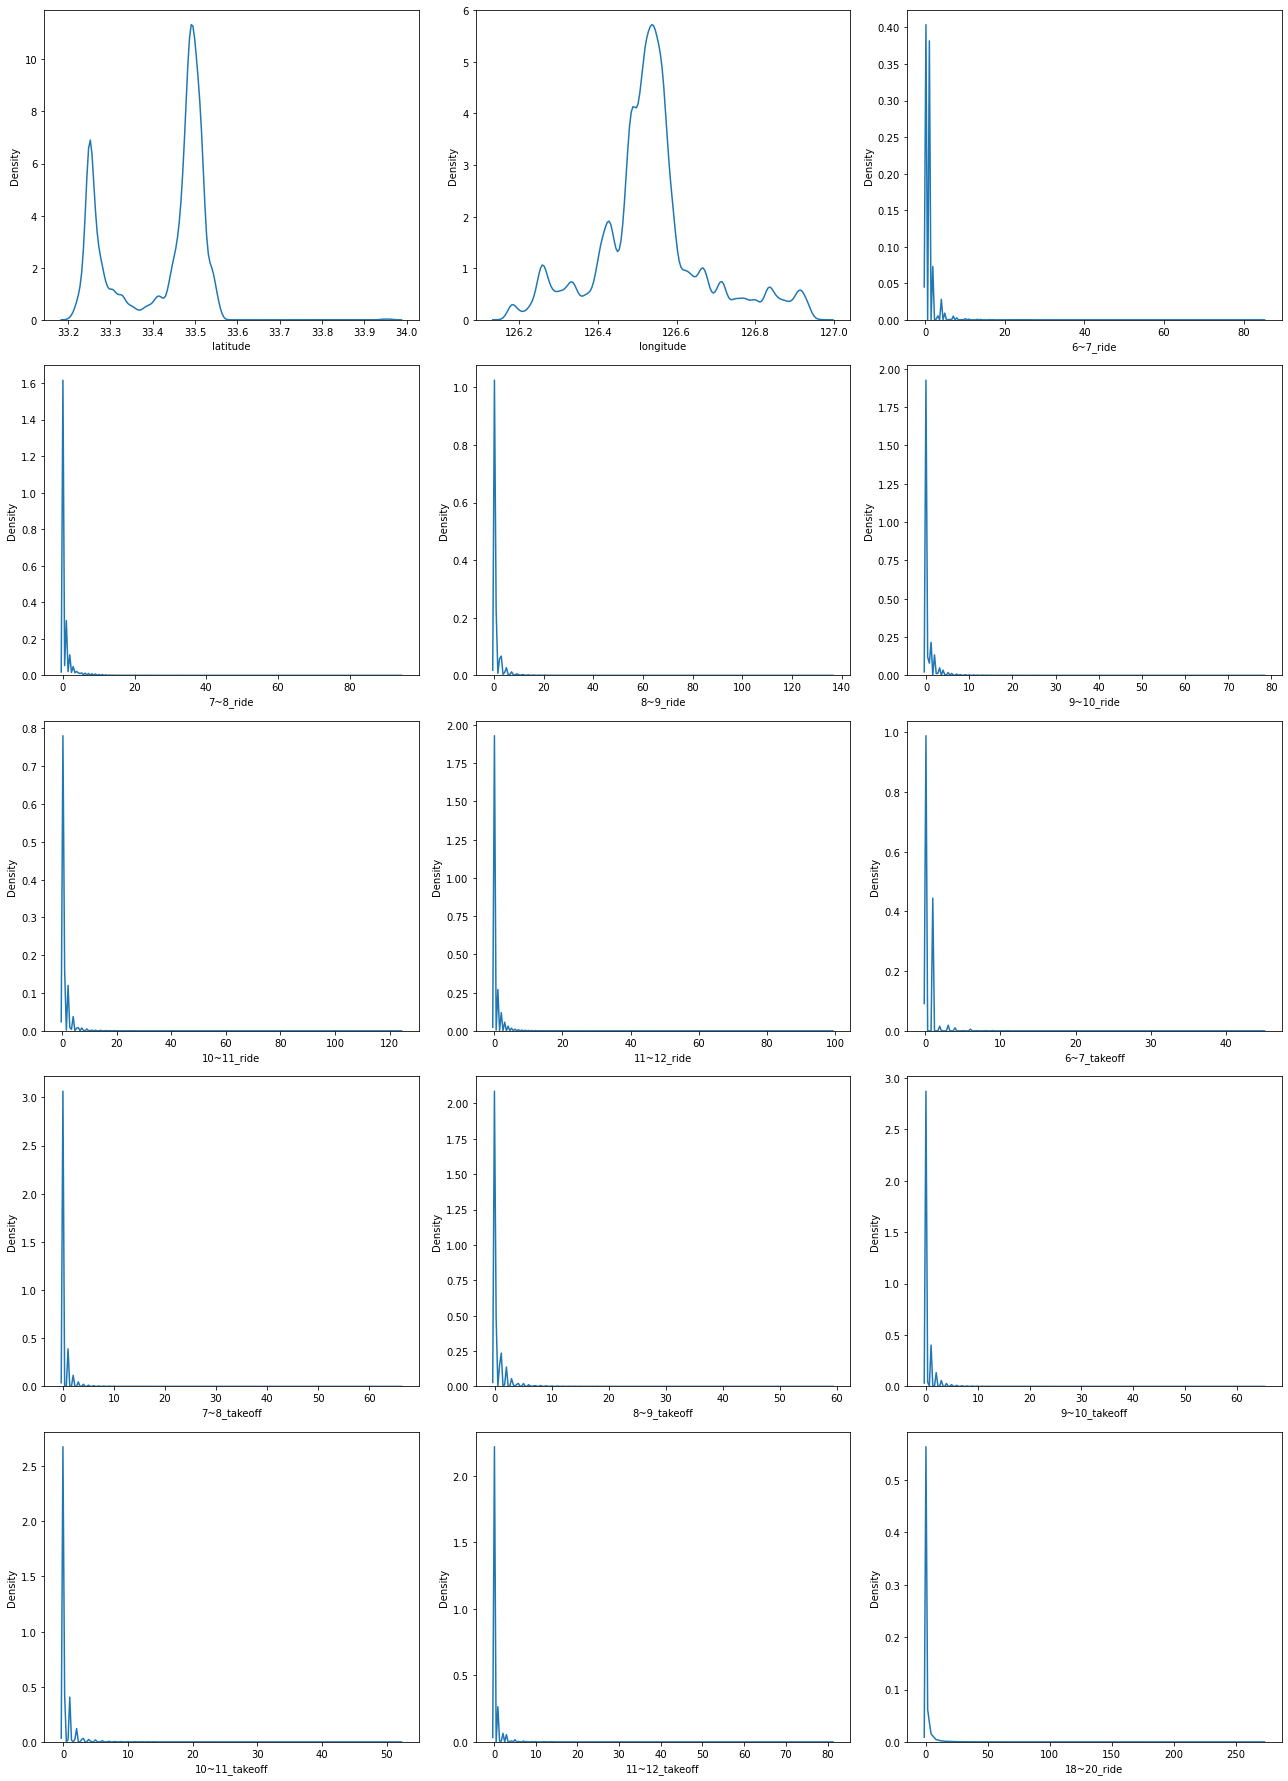

In [73]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 25))

for i in range (5):
    for j in range (3):
        sns.distplot(train[numerical[i][j]], kde=True, hist=False, ax=axes[i][j])

plt.suptitle('')
plt.tight_layout()
plt.show()

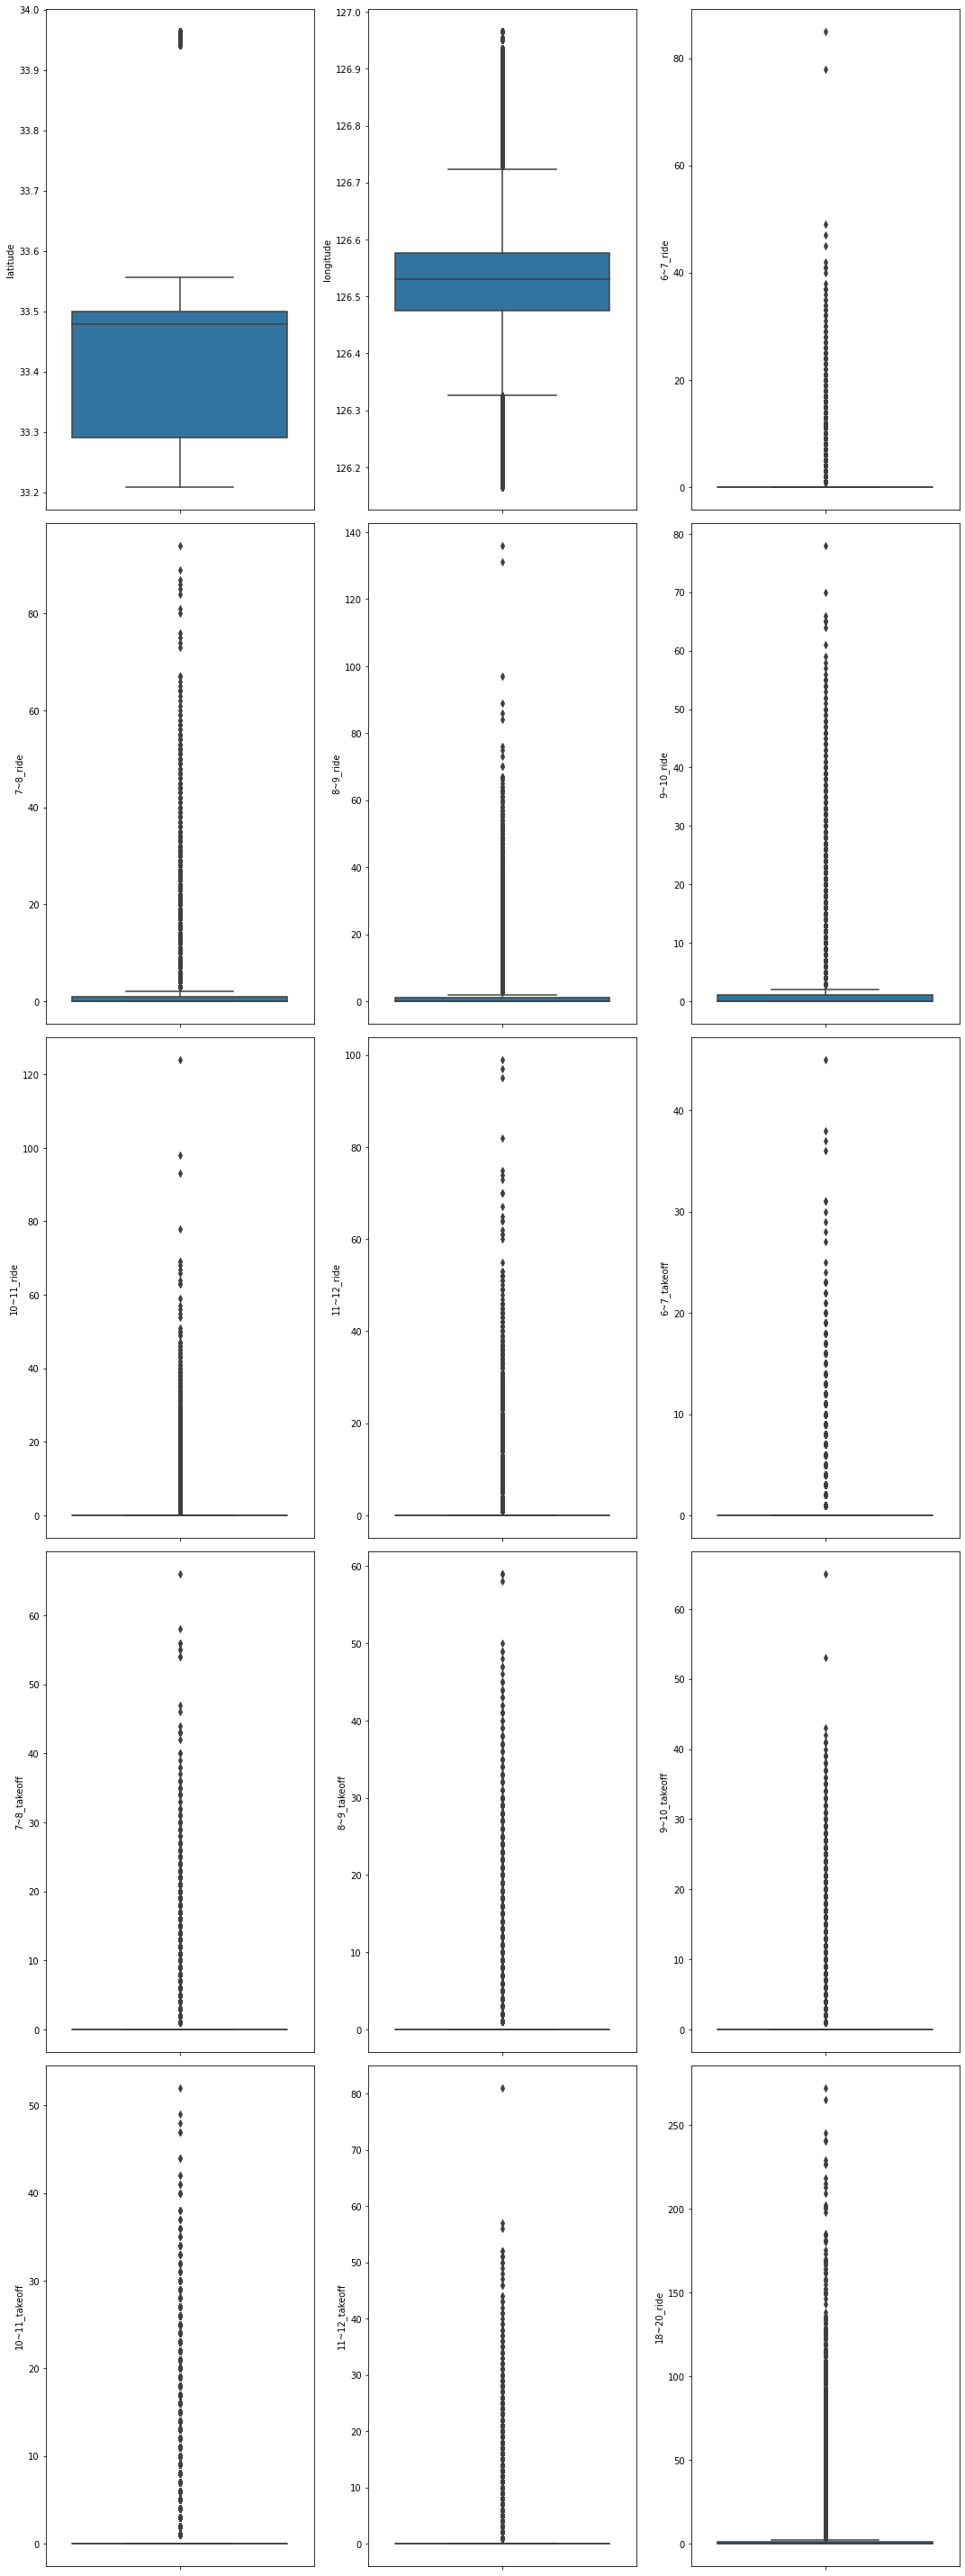

In [75]:
# 수치형 변수 박스플롯
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 40))

for i in range (5):
    for j in range (3):
        sns.boxplot(y=numerical[i][j], data=train, ax=axes[i][j])

plt.suptitle('')
plt.tight_layout()
plt.show()

### 데이터 스케일링의 종류     
references : https://wooono.tistory.com/96 
1. StandardScaler  
- 평균0, 표준편차1로 조정, 모든 특성이 같은 크기 갖도록, 이상치에 민감, 회귀보다 분류에 유용 
2. **MinMaxScaler**
- 최댓값=1, 최솟값=0으로, 이상치에 민감, 분류보다 회귀에 유용 
3. MaxAbsScaler
- 0 기준 절댓값 가장 큰 수가 1 또는 -1이 되도록, 양수데이터로만 구성된 데이터셋에서는 MinMaxScaler와 같음, 분류보다 회귀에 유용  
4. RobustScaler
- 평균과 분산 대신 중앙값=0, IQR=1로 조정, 이상치의 영향 최소화  

**다음에 해야할 일**  
1. 범주형 변수 -> 원핫인코딩 or 라벨인코딩  
2. 수치형 변수 -> 0에 값이 많이 몰려있음 -> 어떤 Scaler 쓸것인지
3. 변수 선택  
4. bus_bts 어떻게 써먹을 수 있을지..?
5. 간단한 모델 돌려보기 -> 최종 데이터셋 선정